In [24]:
import argparse
import os, sys
import time
import datetime
import numpy as np
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from Resnet20model import Resnet20

In [25]:
#############################################
# sanity check for the correctness of Resnet20 architecture
dummy_input = torch.ones((1,3,32,32))
dummy_instance = Resnet20()
print(dummy_instance.forward(dummy_input))
total_params = 1
for p in dummy_instance.parameters():
    temp = 1
    for s in p.size():
        temp *= s
    total_params += temp
    #print(p.size())
print(f"Total Number of Parameters: {total_params}")
#############################################

tensor([[ 0.1705,  0.1036, -0.1232, -0.3745,  0.2621,  0.4375, -0.2515,  0.5034,
          0.1476, -0.2024]], grad_fn=<AddmmBackward0>)
Total Number of Parameters: 273067


In [26]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10 as torchCIFAR10

mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
rndimg_mean = (136.289, 129.273,122.668)
rndimg_std  = (49.770, 49.016, 49.5022508)

# specify preprocessing function
transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std),
                                     transforms.RandomCrop(size=32, padding=4),
                                     transforms.RandomHorizontalFlip()])
tensor_transform_train = transforms.Compose([transforms.Normalize(rndimg_mean, rndimg_std),
                                     transforms.RandomCrop(size=32, padding=4),
                                     transforms.RandomHorizontalFlip()])

transform_val = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

transform_visulaizer = transforms.Compose([transforms.ToTensor()])

In [27]:
# Custom dataset class for tensor datasets. (Allows transforms)

class OODTensorDataset:
    def __init__(self, tensor_data, transforms=None):
        self.tensors = tensor_data
        self.transforms = transforms
    
    def __getitem__(self, index):   
        x = self.tensors[index]
        if self.transforms:
            x = self.transforms(x)
        return x, -1                 # returing -1 for OOD labels to signify that they dont matter
    
    def __len__(self):
        return self.tensors.size()[0]


##### Set up Data loaders

In [45]:
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100

DATA_ROOT = "./data"
RANDOM_IMGS = "./data/300K_random_images.npy"
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 100
OOD_BATCH_SIZE = 256

# construct dataset
random_images_data = torch.permute(torch.from_numpy(np.load(RANDOM_IMGS)), (0,3,1,2)).float()  
rand_img_set = OODTensorDataset(
    random_images_data,
    tensor_transform_train
)
torch_train_set = torchCIFAR10(
    root=DATA_ROOT,
    train=True,
    transform=transform_train,
    download=True
)
torch_test_set = torchCIFAR10(
    root=DATA_ROOT,
    train=False,
    transform=transform_test,
    download=True
)
torch_vis_set = torchCIFAR10(
    root=DATA_ROOT,
    train=False,
    transform=transform_visulaizer,
    download=True
)


# construct dataloader
train_loader_ood = DataLoader(
    rand_img_set,
    batch_size = OOD_BATCH_SIZE,
    shuffle = True
)
train_loader = DataLoader(
    torch_train_set,
    batch_size = TRAIN_BATCH_SIZE
)
test_loader = DataLoader(
    torch_test_set,
    batch_size = TEST_BATCH_SIZE
)
torch_visualizer_loader = DataLoader(
    torch_vis_set
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [30]:
def estimate_mean_and_std(npdata, N=1000):
    pavg   = np.array([0.0, 0.0, 0.0])
    stdavg = np.array([0.0, 0.0, 0.0])
    for img in npdata[0:N]:
        scale = 1/(img.shape[0]*img.shape[1])
        pavg += np.sum(img*scale,(0,1))*(1/N)
    print(pavg)
        #pavg_sq += np.sum((img**2)*scale,(0,1))*(1/N)
    #std = np.sqrt(pavg_sq-(pavg**2))
    for img in npdata[0:N]:
        # scale = 1/(img.shape[0]*img.shape[1])
        # sqdiff = np.subtract(img, pavg)**2
        # std = np.sqrt(np.sum(sqdiff,(0,1))*scale)
        stdavg += np.std(img,(0,1)) *(1/N)
    
    print(stdavg)
estimate_mean_and_std(np.load(RANDOM_IMGS).astype("int32"))

[136.28933887 129.27387598 122.66873633]
[49.770384   49.01616154 49.5022508 ]


In [31]:
# specify the device for computation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [40]:
net = Resnet20().to(device)
#net.load_state_dict(torch.load("saved_model/resnet20.pth")["state_dict"])

In [41]:
import torch.nn as nn
import torch.optim as optim

WARMUP_LR = .01
MOMENTUM = 0.9
REG = 5e-4
optimizer = optim.SGD(net.parameters(), lr=WARMUP_LR, momentum=MOMENTUM, weight_decay=REG)

EPOCHS = 100
CHECKPOINT_FOLDER = "./saved_model"
INITAL_LR = .1
DECAY_EPOCHS = 60
DECAY = .1
# INITAL_LR = .01
# DECAY_EPOCHS = 60
# DECAY = .1

In [42]:
def train():
    avg_loss = 0
    best_val_acc = 0
    current_learning_rate = WARMUP_LR
    train_loader_ood.dataset.offset = np.random.randint(len(train_loader_ood.dataset))
    #Learning rate scheduler
    for i in range(EPOCHS):
        if i == 5:
            current_learning_rate = INITAL_LR
        if i % DECAY_EPOCHS == 0 and i != 0:
            current_learning_rate = current_learning_rate * DECAY
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_learning_rate
            #print("Current learning rate has decayed to %f" %current_learning_rate)
    
        net.train()
        
        print(f"Epoch: {i}/{EPOCHS}")
        for in_set, out_set in zip(train_loader, train_loader_ood):
            data = torch.cat((in_set[0], out_set[0]), 0)
            target = in_set[1].type(torch.LongTensor)
            data, target = data.to(device), target.to(device)
            
            # Forward Pass
            x = net.forward(data)
            
            loss = F.cross_entropy(x[:len(in_set[0])], target)
            # cross-entropy from softmax distribution to uniform distribution
            loss += 0.5 * -(x[len(in_set[0]):].mean(1) - torch.logsumexp(x[len(in_set[0]):], dim=1)).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_loss = .8 * avg_loss + float(loss) * 0.2
       
        print(f"avg training loss: {avg_loss}")
        
        
        net.eval()

        total_examples = 0
        correct_examples = 0

        val_loss = 0

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(test_loader):
                if batch_idx < .5*len(test_loader):
                    # copy inputs to device
                    inputs = inputs.to(device)
                    targets = targets.type(torch.LongTensor)
                    targets = targets.to(device)

                    # compute the output and loss
                    output = net.forward(inputs)
                    loss = F.cross_entropy(output, targets)
                    val_loss += loss

                    # count the number of correctly predicted samples in the current batch
                    total_examples += targets.size()[0]
                    batch_preds = torch.argmax(output, dim=1)
                    correct_examples += (batch_preds == targets).int().sum().item()
                else:
                    break

        avg_loss = val_loss / (.5*len(test_loader))
        avg_acc = correct_examples / total_examples
        print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
        
        #save the model checkpoint
        if avg_acc > best_val_acc:
            best_val_acc = avg_acc
            if not os.path.exists(CHECKPOINT_FOLDER):
               os.makedirs(CHECKPOINT_FOLDER)
            print("Saving ...")
            state = {'state_dict': net.state_dict(),
                    'epoch': i,
                    'lr': current_learning_rate}
            torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'OE_resnet20.pth'))

    
train()

Epoch: 0/100
avg training loss: 2.541567147166714
Validation loss: 1.2743, Validation accuracy: 0.5504
Saving ...
Epoch: 1/100
avg training loss: 2.2424988746643066
Validation loss: 0.9705, Validation accuracy: 0.6668
Saving ...
Epoch: 2/100
avg training loss: 2.1015665531158447
Validation loss: 0.9415, Validation accuracy: 0.7036
Saving ...
Epoch: 3/100
avg training loss: 2.0178918838500977
Validation loss: 0.8582, Validation accuracy: 0.7260
Saving ...
Epoch: 4/100
avg training loss: 1.9493374824523926
Validation loss: 0.8074, Validation accuracy: 0.7436
Saving ...
Epoch: 5/100
avg training loss: 1.8919341564178467
Validation loss: 0.6900, Validation accuracy: 0.7888
Saving ...
Epoch: 6/100


KeyboardInterrupt: 

In [40]:
net = Resnet20().to(device)
net.load_state_dict(torch.load("saved_model/OE_finetune_resnet20.pth")["state_dict"])
net.eval()

val_loss = 0 
max_softs_in = []
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):   #batch_idx, (inputs, targets)
        if batch_idx > .5*len(test_loader):
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.type(torch.LongTensor)
            targets = targets.to(device)
            # compute the output and loss
            output = net.forward(inputs)
            softmax = F.softmax(output, dim=1)
            loss = F.cross_entropy(output, targets)
            val_loss += loss
            # count the number of correctly predicted samples in the current batch
            total_examples += targets.size()[0]
            batch_preds = torch.argmax(output, dim=1)
            soft_batch_preds = torch.argmax(softmax, dim=1)
            for i in range(len(softmax)):
                max_softs_in.append(softmax[i][soft_batch_preds[i]].item())


In [41]:
def plot_roc(false_softs, true_softs, title = "ROC Curve", show_95TPR = True, show_OPT = False):
    TPRs = []     #  true positive rates
    FPRs = []     # false positive rates
    AUROC = []    # will contain the AUROC approximation segments
    opt = {"thresh":-1, "diff":-1, "FPR":-1, "TPR":-1}
    FPR_at_TPR95 = -1
    closest_TPR_to95 = -1
    prev_FPR = 0
    ct95 = 1
    for i in np.sort(np.concatenate((np.linspace(0, .8, 1000), np.linspace(.8,1,3000)))):
        TPR = sum(false_softs < i)/len(false_softs)
        FPR = sum(true_softs < i)/len(true_softs)
        AUROC.append((FPR-prev_FPR)*TPR)
        prev_FPR = FPR
        dis_from_95 = .95-TPR
        if dis_from_95 < ct95:
            ct95 = dis_from_95
            FPR_at_TPR95 = FPR
            closest_TPR_to95 = TPR
        # if round(TPR,2) == .95:
        #     FPR_at_TPR95 = FPR
        TPRs.append(TPR)
        FPRs.append(FPR)
        if TPR-FPR > opt["diff"]:
            opt["thresh"], opt["diff"], opt["FPR"], opt["TPR"]  = i, TPR-FPR, FPR, TPR
    plt.plot(FPRs, TPRs, 'm')
    plt.plot([0,1], [0,1], "k--", linewidth=.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    if show_95TPR:
        plt.plot(FPR_at_TPR95, closest_TPR_to95, 'X', ms=11, label=f"FPR@95TPR: {round(FPR_at_TPR95,3)}")
    if show_OPT:
        plt.plot(opt["FPR"], opt["TPR"], 'X', ms=11, label=f"OPT Thresh: {round(opt['thresh'],3)}")
        print(opt)
    plt.legend()
    plt.show()
    print(f"AUROC: {sum(AUROC)}")

In [42]:
from torchvision.datasets import CIFAR100
from torchvision.datasets import SVHN

cifar100_set = CIFAR100(
    root=DATA_ROOT,
    train=False,
    transform=transform_test,
    download=True
)
SVHN_set = SVHN(
    root=DATA_ROOT,
    split="test",
    transform=transform_test,
    download=True
)

cifar100_loader = DataLoader(
    cifar100_set
)
SVHN_loader = DataLoader(
    SVHN_set
)



Files already downloaded and verified
Using downloaded and verified file: ./data\test_32x32.mat


In [43]:
OOD_cifar100_softs = []
with torch.no_grad():
    for i, (img, target) in enumerate(cifar100_loader):
        img = img.to(device)
        target = target.type(torch.LongTensor)
        target = target.to(device)

        output = net.forward(img)
        softmax = F.softmax(output, dim=1)
        OOD_cifar100_softs.append(softmax[0][torch.argmax(softmax)].item())
        batch_pred = torch.argmax(output, dim=1)
        if i%1000 == 0:
            print(f"{i}/{len(cifar100_loader)}")

0/10000
1000/10000
2000/10000
3000/10000
4000/10000
5000/10000
6000/10000
7000/10000
8000/10000
9000/10000


In [25]:
OOD_svhn_softs = []
with torch.no_grad():
    for i, (img, target) in enumerate(SVHN_loader):
        img = img.to(device)
        target = target.type(torch.LongTensor)
        target = target.to(device)

        output = net.forward(img)
        softmax = F.softmax(output, dim=1)
        OOD_svhn_softs.append(softmax[0][torch.argmax(softmax)].item())
        batch_pred = torch.argmax(output, dim=1)
        if i%1000 == 0:
            print(f"{i}/{len(SVHN_loader)}")

0/26032
1000/26032
2000/26032
3000/26032
4000/26032
5000/26032
6000/26032
7000/26032
8000/26032
9000/26032
10000/26032
11000/26032
12000/26032
13000/26032
14000/26032
15000/26032
16000/26032
17000/26032
18000/26032
19000/26032
20000/26032
21000/26032
22000/26032
23000/26032
24000/26032
25000/26032
26000/26032


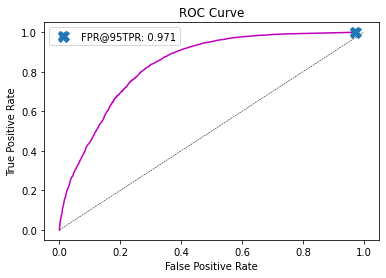

AUROC: 0.8089219189189192


In [44]:
plot_roc(OOD_cifar100_softs, max_softs_in)

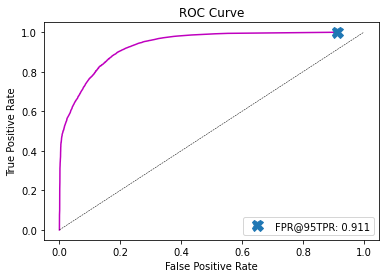

AUROC: 0.8467976938985697


In [26]:
plot_roc(OOD_svhn_softs, max_softs_in)